# Gradient Clipping and Adaptive Learning Rates
> Understand how gradient clipping and adaptive learning rates relate to stable model training.

- toc: true
- badges: true
- comments: true
- sticky_rank: 1
- author: Abhishek Sharma
- image: images/gradient_clip.png
- categories: [optimization, math, deeplearning, fast.ai]

## Introduction

Gradient clipping is a common technique to make model training more stable. It's operation could be expressed as

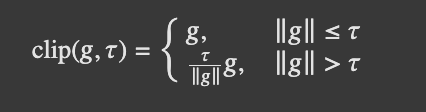

* The clipping threshold τ is often set to 1. Is this just a default value, or is there something deeper?

The above formula ensures that if your gradient's magnitude exceeds τ, it gets scaled down while maintaining the direction.

* But what exactly is ‖g‖, it is defined as "global gradient norm" in the literature

Let's try to understand it with a simple example, imagine a tiny neural network

```
layer1 = Linear(2, 2)  # 2x2 weight matrix + 2 biases = 6 parameters
layer2 = Linear(2, 1)  # 2x1 weight matrix + 1 bias = 3 parameters
```

When computing gradients, each parameter gets its own gradient. The global gradient norm is calculated by:

1. Flattening all gradients into one long vector
2. Computing the L2 norm ( Euclidean Norm ) of this vector

It is like measuring the "overall strength" of all gradients combined.

* But why τ=1 works so well. What's the mathematical intuition?

The key insight comes from looking at how model updates affect the loss function. For SGD, we can write

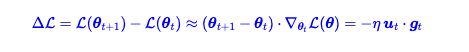

For vanilla SGD $$u_t = g_t$$

We can rewrite the above equation as

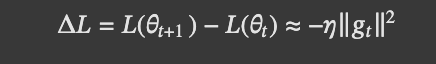

The key insight is that change in loss is proportional to the square of the gradient norm. For stable training, we typically want |ΔL| < η ( change in loss to be less than the learning rate ).

Therefore:

|-η‖gt‖²| < η

η‖gt‖² < η

‖gt‖² < 1

‖gt‖ < 1

Let's try to verify this claim by running some experiments on MNIST dataset using fast.ai

In [ ]:
from __future__ import annotations
from fastai.torch_basics import *
from fastai.vision.all import *

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from functools import partial

In [ ]:
class GradientTracker(Callback):
    """Callback to track gradient norms during training"""
    def __init__(self):
        self.grad_norms = []
        self.loss_changes = []
        self.last_loss = None

    def before_batch(self):
        # Store the loss value before the batch
        if self.learn.loss_func is not None:
            self.last_loss = self.learn.loss.item() if self.learn.loss is not None else None

    def after_backward(self):
        # Calculate global gradient norm
        total_norm = 0.
        for p in self.learn.model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        self.grad_norms.append(total_norm)

        # Calculate change in loss
        if self.last_loss is not None and self.learn.loss is not None:
            loss_change = abs(self.learn.loss.item() - self.last_loss)
            self.loss_changes.append(loss_change)

    def plot_stats(self):
        """Plot gradient norms and loss changes"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Plot gradient norms
        ax1.plot(self.grad_norms)
        ax1.axhline(y=1.0, color='r', linestyle='--', label='τ=1.0')
        ax1.set_title('Gradient Norms During Training')
        ax1.set_xlabel('Batch')
        ax1.set_ylabel('Global Gradient Norm')
        ax1.legend()

        # Plot loss changes
        ax2.plot(self.loss_changes)
        ax2.axhline(y=self.learn.lr, color='r', linestyle='--', label=f'η={self.learn.lr}')
        ax2.set_title('Absolute Loss Changes During Training')
        ax2.set_xlabel('Batch')
        ax2.set_ylabel('|ΔL|')
        ax2.legend()

        plt.tight_layout()
        return fig

In [ ]:
def create_experiment(clip=True):
  path = untar_data(URLs.MNIST)
  dls  = ImageDataLoaders.from_folder(path,
                                    valid_pct=0.2,
                                    batch_size=128,
                                    item_tfms=Resize(28),
                                    n_inp=1
                                    )

  model = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(32 * 7 * 7, 10)
    )

  # Create learner with gradient tracking
  learn = Learner(dls, model, metrics=accuracy)
  grad_tracker = GradientTracker()
  learn.add_cb(grad_tracker)

  # Add gradient clipping if specified
  if clip:
      learn.add_cb(GradientClip(max_norm=1.0))

  # Train for a few epochs
  learn.fit_one_cycle(5, 1e-2)

  return learn, grad_tracker

In [ ]:
# Run experiments with and without gradient clipping
learn_clip, tracker_clip = create_experiment(clip=True)
learn_no_clip, tracker_no_clip = create_experiment(clip=False)

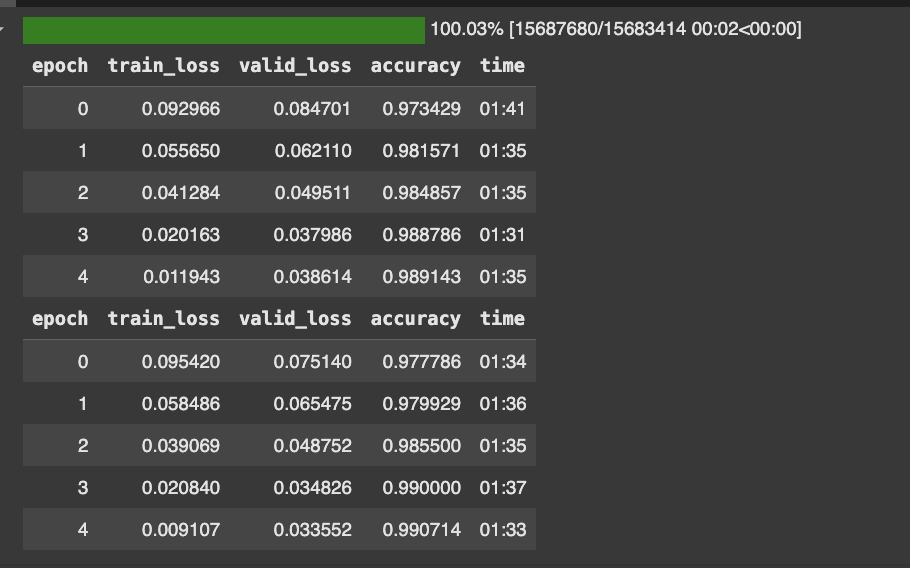

In [ ]:
# Plot and compare results
fig_clip = tracker_clip.plot_stats()
plt.suptitle('With Gradient Clipping (τ=1.0)')

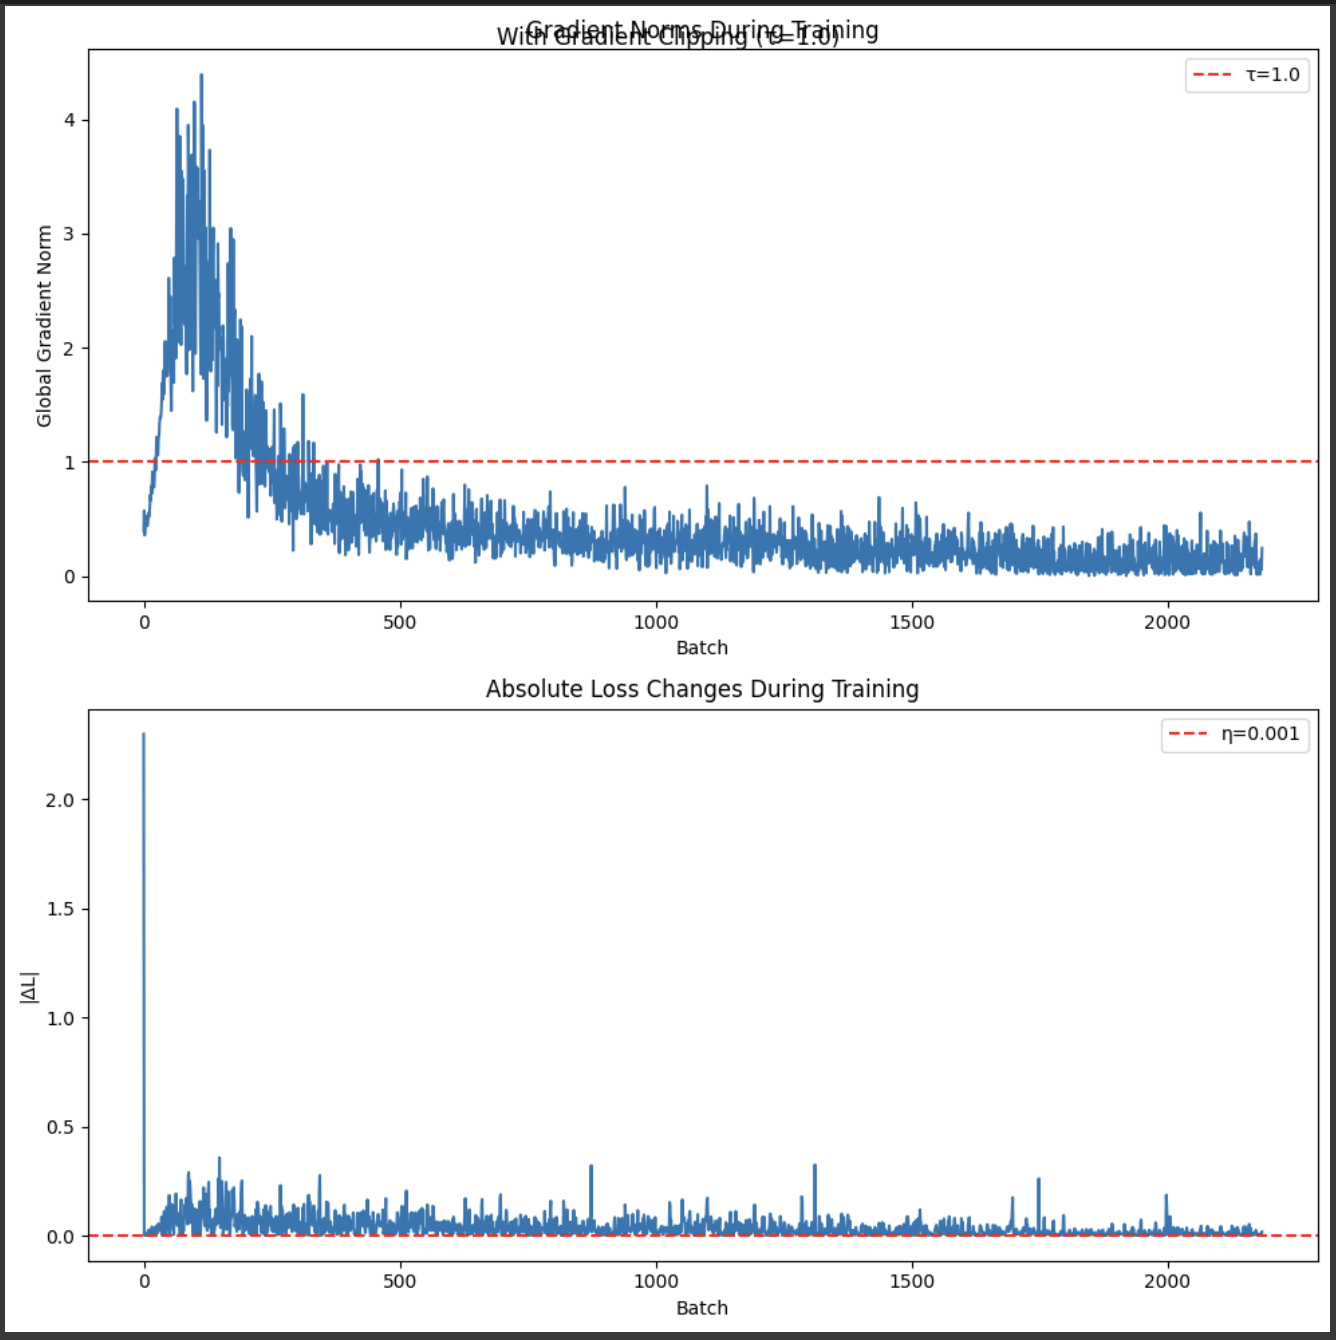

In [ ]:
fig_no_clip = tracker_no_clip.plot_stats()
plt.suptitle('Without Gradient Clipping')

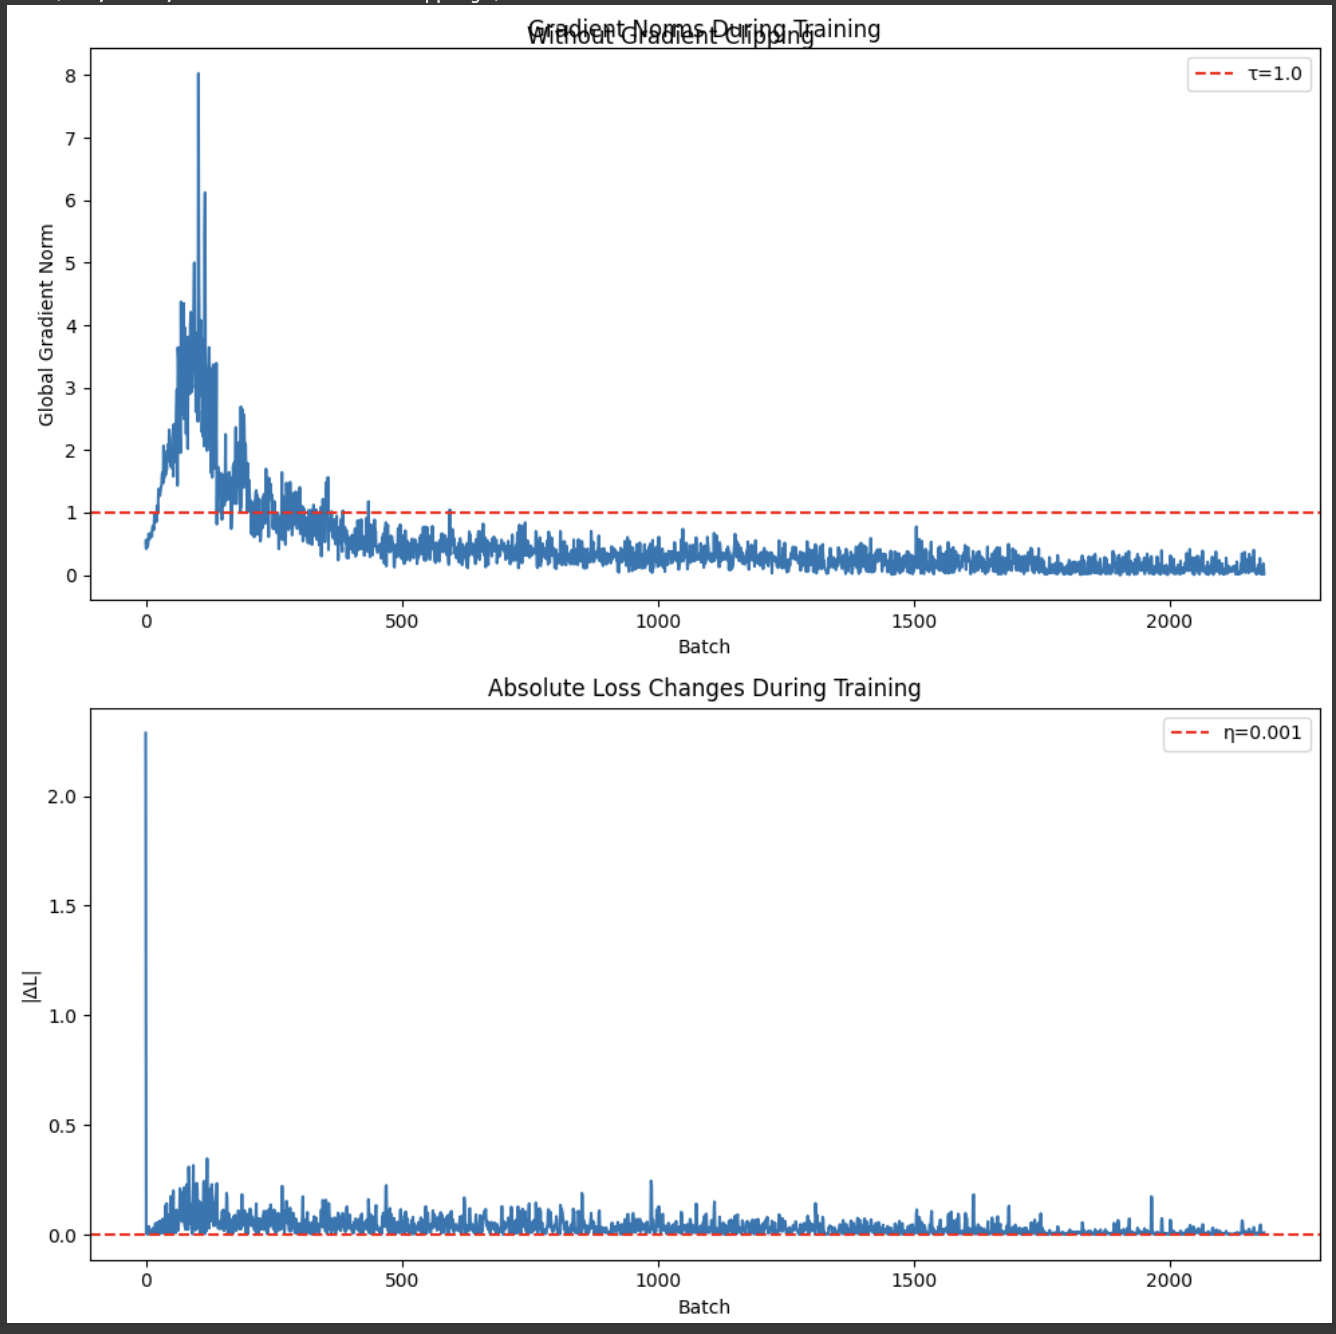

In [ ]:
comparison = pd.DataFrame({
    'Metric': ['Mean Gradient Norm', 'Max Gradient Norm', 'Mean |ΔL|', 'Max |ΔL|'],
    'With Clipping': [
        np.mean(tracker_clip.grad_norms),
        np.max(tracker_clip.grad_norms),
        np.mean(tracker_clip.loss_changes),
        np.max(tracker_clip.loss_changes)
    ],
    'Without Clipping': [
        np.mean(tracker_no_clip.grad_norms),
        np.max(tracker_no_clip.grad_norms),
        np.mean(tracker_no_clip.loss_changes),
        np.max(tracker_no_clip.loss_changes)
    ]
})

print("\nComparison Statistics:")
print(comparison.to_string(index=False))

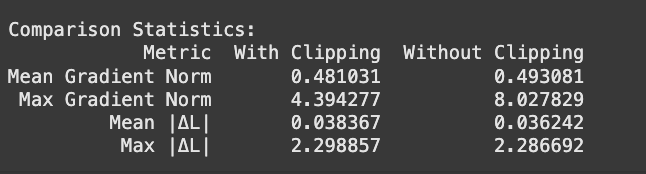

What the above experiment suggests that

1. Early Training ( 0-500 batches ):
  * Global Gradient Norm naturally start large ( > 1)
  * Without clipping, they reached 8.0
  * With clipping, they were capped at ~4

2. Middle/Late Training ( 500+ batches )
  * Both experiments naturally converged to gradient norms < 1
  * Mean gradient norms were similar ( 0.48 v 0.49 )

This confirms that ||g|| < 1 is indeed the natural state of a well trained model.

We also know from literature that if the gradient modulus is significanly greather than 1 in the early state, then usual strategy is warmup ir we can consider a more general strategy: set another threshold $\tau$

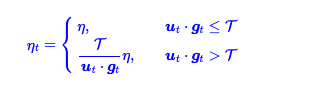

For optimizers like Adam

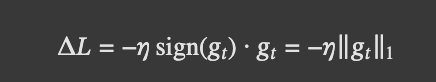

How does $u_t$ becomes $sign(g_t)$ and $sign(g_t)$ . $g_t$ becomes $\|g_t\|_1$?

$u_t$ = $sign(g_t)$ because Adam's updates tend to normalize gradient magnitudes while preserving direction.

And when we multiply a number by it's sign, you get its absolute value.

This explains why Adam typically needs smaller learnings rates than SGD as L1 norm is usually larger than L2 norm.

The above formula could also be written as

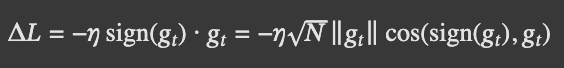

Since $sign(g_t)$ is a vector of either +1 or -1 thereforme $||sign(g_t)||^2$ = N so therefore $||sign(g_t)||$ = $\sqrt(N)$

and

a . b = ||a|| . ||b||. cos(a, b)

therefore

$sign(g_t) . gt$ = $\sqrt(N) . ||g_t|| . cos(sign(g_t), g_t)$. $cos(sign(g_t, g_t))$ is roughly constant across model scales so if we want to maintain $\Delta L$ $\eta$ should be inversely proportional to $\sqrt(N)$, which means if the number of model parameter increases by 4 times, learning rate can be halved.

## Takeaways


* τ=1 isn't arbitrary - it aligns with the natural scale of gradients during stable training.
* The relationship |ΔL| < η mathematically explains why gradients naturally stay below 1 during stable training.
* Different optimizers (SGD vs Adam) have different relationships between gradients and loss changes, which affects their learning rate requirements.
* When scaling to larger models, learning rates should scale with 1/√N (where N is parameter count) to maintain consistent training dynamics.

This understanding helps us move from blindly using default values to making principled decisions about optimization hyperparameters in deep learning!

## References

* https://kexue.fm/archives/10657
* https://papers.cool/arxiv/2310.07831